In [51]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Load dataset

In [48]:
# Google dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [52]:
# Our dataset
PATH = "datasets/Qualite"

In [50]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/Qualite/train'

In [53]:
# Our
batch_size = 32
img_height = 300
img_width = 300
IMG_SIZE = (img_width, img_height)

train_ds = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
validation_ds = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18695 files belonging to 4 classes.
Using 14956 files for training.
Found 18695 files belonging to 4 classes.
Using 3739 files for validation.


In [54]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=468>

In [55]:
# Crée jeu de tests
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [56]:
# étiquettes
class_names = ["FaceQual0","FaceQual1","FaceQual2","FaceQual3"]

In [57]:
# normalisation

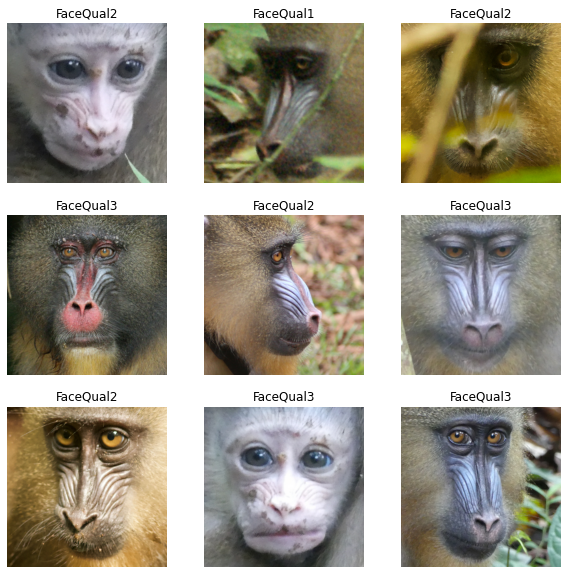

In [58]:
# affichage
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Load MobileNetV2 model

In [59]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # modele MobileNet V2 (rapide et correct)
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # [0, 255] => [-1, 1]

In [63]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 3s 0us/step


In [65]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1280)


In [66]:
# gel : a voir
base_model.trainable = False

In [67]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [75]:
prediction_layer = tf.keras.layers.Dense(4, activation="softmax") # prédiction sur 4 classes (4 neurones)

In [76]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False) # mobile net v2
x = global_average_layer(x) # moyenne des features
outputs = prediction_layer(x) # prediction
model = tf.keras.Model(inputs, outputs)

In [77]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [78]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)

 52/117 [============>.................] - ETA: 1:06 - loss: 1.6638 - accuracy: 0.0992

KeyboardInterrupt: 

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

In [ ]:
# graphes accuracy + loss
# si c'est pas mal on passe à la suite, sinon on refait au dessus
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# On fine-tune le modèle une fois qu'il a "appris au maximum"
=> unfreezing de layers supérieurs

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), # learning rate + faible que dans la 1re partie
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
# graphes accuracy + loss
# si c'est pas mal on passe à la suite, sinon on refait au dessus
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()